In [5]:
from PIL import Image, ImageOps
import os
import numpy as np
import pandas as pd
from pycocotools.coco import COCO
import pycocotools.mask as cmask

In [6]:
# CONSTANTS
SIDE_LENGTH = 64
COCO_PATH = './../data/COCO'

#PATHS
COCO_VAL_IMG_PATH = os.path.join(COCO_PATH, 'val2017/images')

In [7]:
def resizeImage(im, side_length):
    old_size = im.size
    ratio = float(side_length)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = im.resize(new_size, Image.ANTIALIAS)
    new_im = Image.new("RGB", (side_length, side_length))
    new_im.paste(im, ((side_length-new_size[0])//2,
                        (side_length-new_size[1])//2))

    return new_im

In [4]:
mask = (np.random.random((32, 20)) > 0.5) * 1

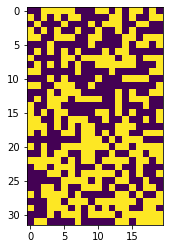

In [5]:
import matplotlib.pyplot as plt
plt.imshow(mask)

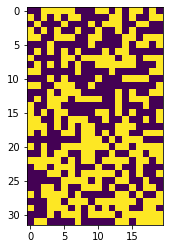

In [6]:
im = np.array(Image.fromarray(mask.astype(bool), mode='L'))
plt.imshow(im, vmin=0, vmax=1)

In [7]:
print(im.size)

640


In [8]:
im = im.reshape(32, 20)

In [4]:
def resizeMask(im, side_length):
    old_size = im.size
    ratio = float(side_length)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = im.resize(new_size, Image.ANTIALIAS)
    new_im = Image.new('L', (side_length, side_length))
    new_im.paste(im, ((side_length-new_size[0])//2,
                        (side_length-new_size[1])//2))

    return new_im

In [5]:
new_image = resizeMask(im, SIDE_LENGTH)
plt.imshow(new_image)

NameError: name 'im' is not defined

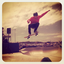

In [11]:
# Sample
path = os.path.join(COCO_VAL_IMG_PATH, '000000581357.jpg')
resizeImage(Image.open(path), SIDE_LENGTH)

In [12]:
val_ids = np.load('val_indexes.npy')
val_map = np.load('val_map.npy', allow_pickle=True).item()

In [70]:
print(n_ids)

NameError: name 'n_ids' is not defined

In [71]:
# # Loop through IDs, create path w/ IDs, and make into tensor
# x_val = []
# y_val = []

# n_ids = len(val_ids)
# for i in range(n_ids):
#     if i % 300 == 0:
#         print('Iteration', i)
#     pid = val_ids[i]
#     im_path = os.path.join(COCO_VAL_IMG_PATH, str(pid).zfill(12) + '.jpg')
#     im = np.array(Image.open(im_path))
#     if (len(im.shape) < 3):
#         continue
#     image_data = val_map[pid]
    
#     for i in range(len(image_data)):
#         x1, y1, w, h = [int(x) for x in image_data[i][0]]
#         rle_mask = image_data[i][1]
#         decoded = cmask.decode(rle_mask)
#         crop = im[y1:y1+h, x1:x1+w, :]
#         crop_mask = decoded[y1:y1+h, x1:x1+w]
#         crop_resize = resizeImage(Image.fromarray(crop), SIDE_LENGTH)
#         x_val.append(np.array(crop_resize))
        
#         mask_resize = resizeMask(Image.fromarray(crop_mask, mode='L'), SIDE_LENGTH)
#         y_val.append(np.array(mask_resize))

# x_val = np.array(x_val)
# y_val = np.array(y_val)

In [8]:
np.save('x_val.npy', x_val)
np.save('y_val.npy', y_val)

NameError: name 'x_val' is not defined

In [9]:
x_val = np.load('x_val.npy')[:3000]
y_val = np.load('y_val.npy')[:3000]

In [10]:
y_val = y_val.reshape((3000, 4096))

In [11]:
import tensorflow as tf

/home/michael/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/michael/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/michael/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/michael/miniconda3/lib/python3.7/site-packages/tensorflow/python/frame

In [12]:
def binary_crossentropy_with_logits(ground_truth, predictions):
    return K.mean(K.binary_crossentropy(ground_truth,
                                        predictions,
                                        from_logits=False),
                  axis=-1)

In [13]:
%load_ext autoreload
%autoreload

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import os
import sys
import pickle
from keras.optimizers import SGD, Adam, Nadam
from keras.callbacks import *
from keras.objectives import *
from keras.metrics import binary_accuracy
from keras.models import load_model
import keras.backend as K
#import keras.utils.visualize_util as vis_util

from models import *
from utils.loss_function import *
from utils.SegDataGenerator import *
import time


def train(batch_size, epochs, lr_base, lr_power, weight_decay, classes,
          model_name, train_file_path, val_file_path,
          data_dir, label_dir, target_size=None, batchnorm_momentum=0.9,
          resume_training=False, class_weight=None, dataset='VOC2012',
          loss_fn=binary_crossentropy_with_logits,
          metrics=[binary_accuracy],
          loss_shape=None,
          label_suffix='.png',
          data_suffix='.jpg',
          ignore_label=255,
          label_cval=255):
    if target_size:
        input_shape = target_size + (3,)
    else:
        input_shape = (None, None, 3)
    batch_shape = (batch_size,) + input_shape

    ###########################################################
    current_dir = '/home/michael/Code/CS229-Project/Masking'
    save_path = os.path.join(current_dir, 'Models/' + model_name)
    if os.path.exists(save_path) is False:
        os.mkdir(save_path)

    # ###############learning rate scheduler####################
    def lr_scheduler(epoch, mode='adam'):
        '''if lr_dict.has_key(epoch):
            lr = lr_dict[epoch]
            print 'lr: %f' % lr'''
        lr=0.001
        if mode is 'power_decay':
            # original lr scheduler
            lr = lr_base * ((1 - float(epoch)/epochs) ** lr_power)
        if mode is 'exp_decay':
            # exponential decay
            lr = (float(lr_base) ** float(lr_power)) ** float(epoch+1)
        # adam default lr
        if mode is 'adam':
            lr = 0.001

        if mode is 'progressive_drops':
            # drops as progression proceeds, good for sgd
            if epoch > 0.9 * epochs:
                lr = 0.0001
            elif epoch > 0.75 * epochs:
                lr = 0.001
            elif epoch > 0.5 * epochs:
                lr = 0.01
            else:
                lr = 0.1

        print('lr: %f' % lr)
        return lr
    scheduler = LearningRateScheduler(lr_scheduler)

    # ###################### make model ########################
    checkpoint_path = os.path.join(save_path, 'checkpoint_weights.hdf5')

    model = globals()[model_name](weight_decay=weight_decay,
                                  input_shape=input_shape,
                                  batch_momentum=batchnorm_momentum,
                                  classes=classes)

    # ###################### optimizer ########################
#     optimizer = SGD(lr=lr_base, momentum=0.9)
#     optimizer = Nadam(lr=lr_base, beta_1 = 0.825, beta_2 = 0.99685)
    optimizer = Adam(lr=0.001)

    model.compile(loss=loss_fn,
                  optimizer=optimizer,
                  metrics=metrics)
    if resume_training:
        model.load_weights(checkpoint_path, by_name=True)
    model_path = os.path.join(save_path, "model.json")
    # save model structure
    f = open(model_path, 'w')
    model_json = model.to_json()
    f.write(model_json)
    f.close
    img_path = os.path.join(save_path, "model.png")
    # #vis_util.plot(model, to_file=img_path, show_shapes=True)
    model.summary()

    callbacks = []


    # ################### checkpoint saver#######################
    checkpoint = ModelCheckpoint(filepath=os.path.join(save_path, 'checkpoint_weights.hdf5'), save_weights_only=True)#.{epoch:d}
    callbacks.append(checkpoint)

    history = model.fit(x_val, y_val, epochs=epochs, batch_size=batch_size, callbacks=callbacks)

    model.save_weights(save_path+'/model.hdf5')

In [16]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import os
import sys
import pickle
import time
from keras.optimizers import SGD, Adam
from keras.callbacks import *
from keras.objectives import *
from keras.models import load_model
import keras.backend as K
#import keras.utils.visualize_util as vis_util

from models import *
from utils.loss_function import *
from utils.SegDataGenerator import *
# from tf_image_segmentation.recipes.mscoco import data_coco

model_name = 'DenseNet_FCN'
batch_size = 16
batchnorm_momentum = 0.95
epochs = 450
lr_base = 0.01 * (float(batch_size) / 4)
lr_power = float(1)/float(30)
resume_training=False
weight_decay = 0.0001/2
target_size = (64, 64)
dataset = 'COCO'
classes = 1

config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
K.set_session(session)
# train(batch_size, epochs, lr_base, lr_power, weight_decay, classes, model_name, '', '',
#       '', '', target_size=target_size, batchnorm_momentum=batchnorm_momentum, resume_training=resume_training,
#       class_weight=None, dataset=dataset)

In [18]:
path = '/home/michael/Code/CS229-Project/Masking/Models/DenseNet_FCN/checkpoint_weights.hdf5'

In [19]:
model = globals()['DenseNet_FCN'](weight_decay=weight_decay,
                                  input_shape=target_size + (3,),
                                  batch_momentum=batchnorm_momentum,
                                  classes=1)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [20]:
model.load_weights(path)

In [16]:
x_val = np.load('x_val.npy')[3000:6000]
y_val = np.load('y_val.npy')[3000:6000]

In [17]:
print(y_val.shape)

(3000, 64, 64)


In [18]:
prediction = model.predict(x_val)


/home/michael/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


In [1]:
prediction = prediction.reshape(3000, 64, 64)
accuracy = np.sum(y_val == prediction) / (3000*64*64)

NameError: name 'prediction' is not defined

In [26]:
print(accuracy) 

0.8110984375


In [33]:
precision = np.sum((y_val == 1) & (prediction == 1)) / (np.sum((y_val == 1) & (prediction == 1)) + np.sum((y_val == 0) & (prediction == 1)))

In [34]:
print(precision)

0.7008075098772288


In [37]:
recall = np.sum((y_val == 1) & (prediction == 1)) / (np.sum((y_val == 1) & (prediction == 1)) + np.sum((y_val == 1) & (prediction == 0)))

In [38]:
print(recall)

0.8340777461677122


In [ ]:
import keras.backend as K

batch_size = 16
batchnorm_momentum = 0.95
epochs = 250
lr_base = 0.01 * (float(batch_size) / 16)
lr_power = 0.9
resume_training = False
weight_decay = 0.0001/2
target_size = (64, 64)
input_shape = target_size + (3,)

model = AtrousFCN_Resnet50_16s(weight_decay=weight_decay,
                                  input_shape=target_size + (3,),
                                  batch_momentum=batchnorm_momentum,
                                  classes=1)
model.fit(x_val_reshape, y_val_reshape, epochs=epochs, batch_size=batch_size)

In [33]:
ex = np.load('x_val.npy')[3001:3020]
print(ex.shape)
examples = model.predict(ex)

(19, 64, 64, 3)


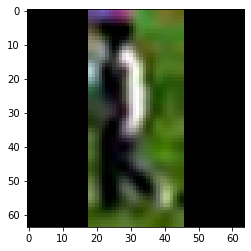

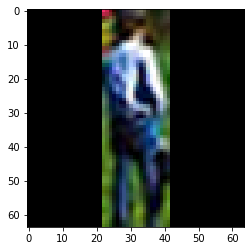

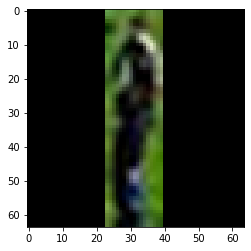

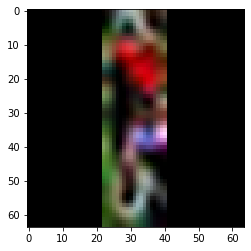

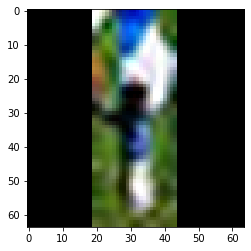

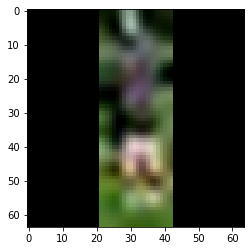

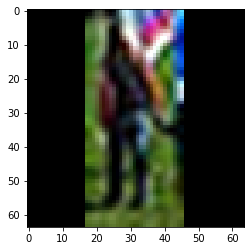

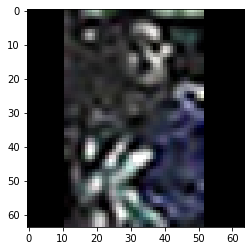

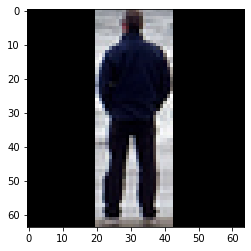

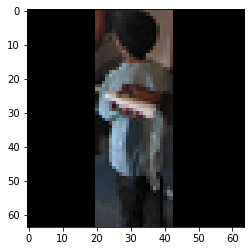

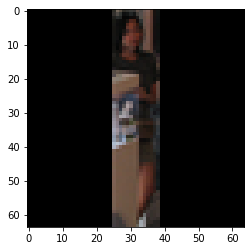

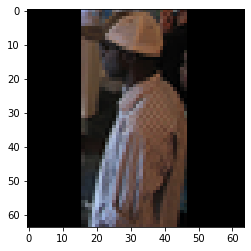

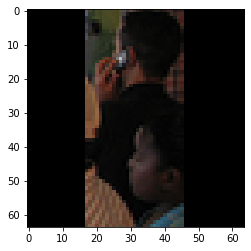

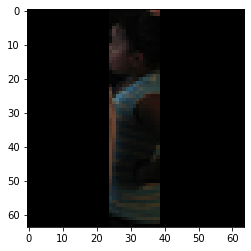

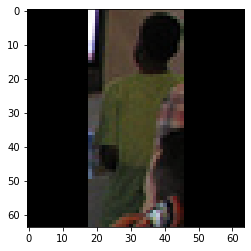

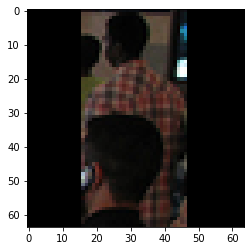

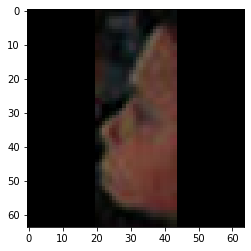

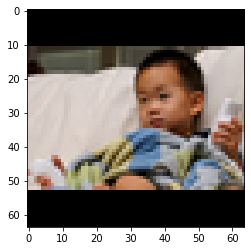

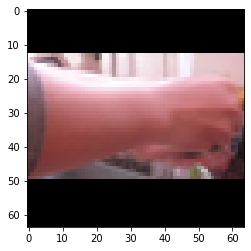

In [34]:
for example in ex:
    example_im = example.reshape((64, 64, 3))
    plt.imshow(example_im)
    plt.show()

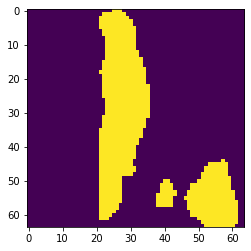

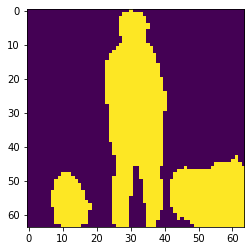

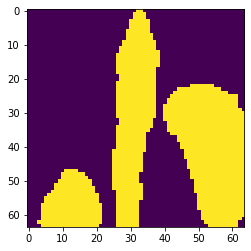

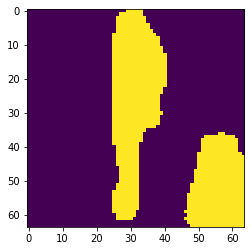

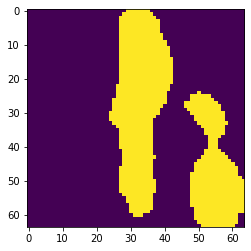

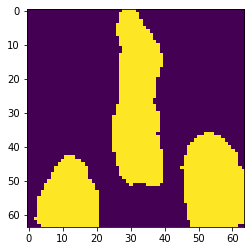

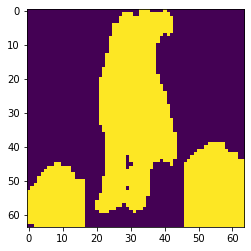

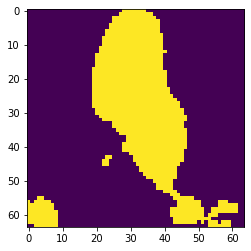

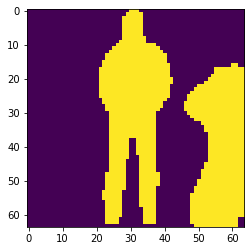

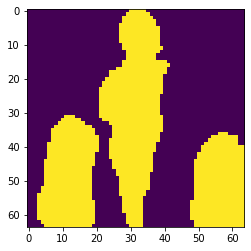

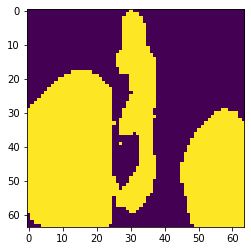

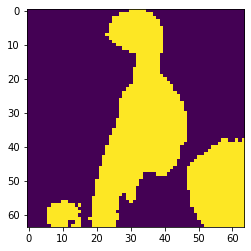

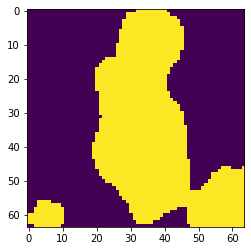

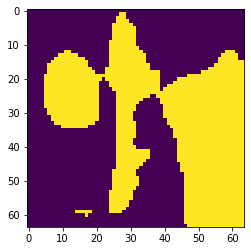

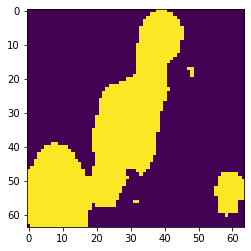

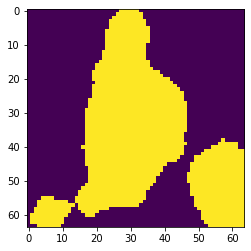

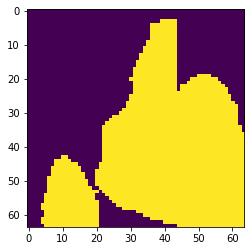

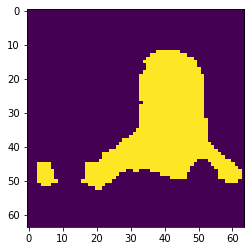

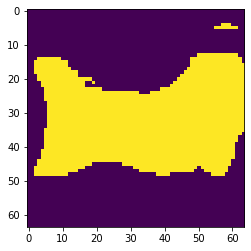

In [35]:
for example in examples:
    example = example > 0.5
    example_im = example.reshape((64, 64))
    plt.imshow(example_im)
    plt.show()

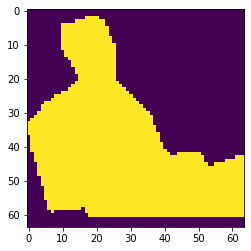

In [36]:
plt.imshow(y_val[1505])

In [39]:
from PIL import Image

def resizeImage(im, side_length):
    old_size = im.size
    ratio = float(side_length)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = im.resize(new_size, Image.ANTIALIAS)
    new_im = Image.new("RGB", (side_length, side_length))
    new_im.paste(im, ((side_length-new_size[0])//2,
                        (side_length-new_size[1])//2))

    return new_im

In [21]:
test_path = '/home/michael/Code/CS229-Project/Masking/test_images2'

images = []
names = []
for i, image_stub in enumerate(os.listdir(test_path)):
    full_path = os.path.join(test_path, image_stub)
    unscaled_image = Image.open(full_path)
    scaled_image = resizeImage(unscaled_image, SIDE_LENGTH)
    names.append(image_stub)
    images.append(np.array(scaled_image))

full_images = np.array(images)
predictions = model.predict(full_images)

for i, prediction in enumerate(predictions):
    fname = names[i][:-4] + 'mask.png'
    plt.imsave(fname, prediction.reshape(64,64) > 0.5)

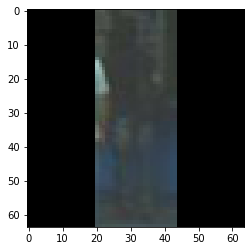

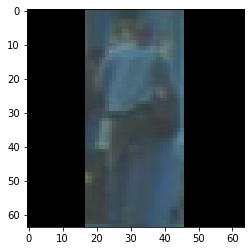

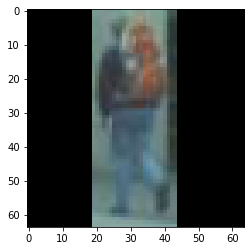

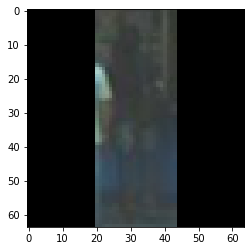

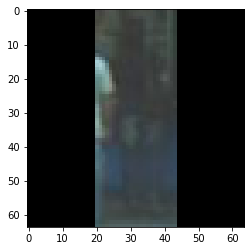

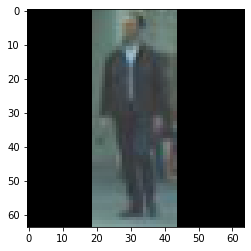

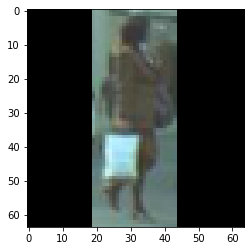

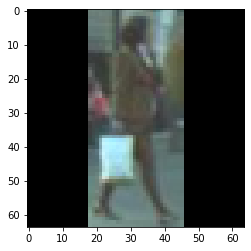

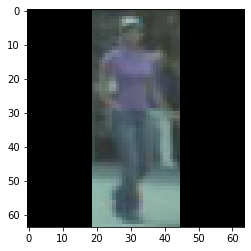

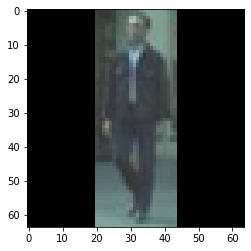

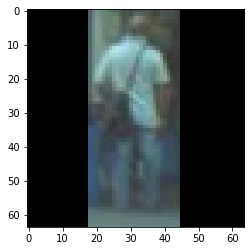

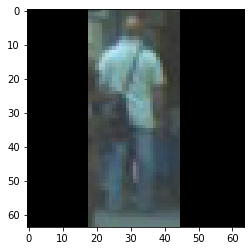

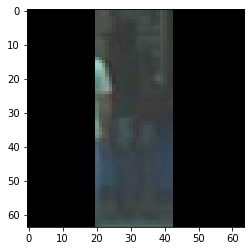

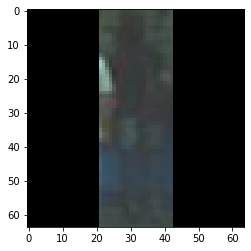

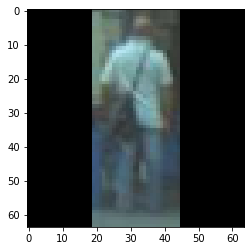

In [41]:
for image in images:
    plt.imshow(image)
    plt.show()

In [30]:
print(x_val.shape)
print(y_val.shape)
print(x_val_reshape.shape)

(10941, 64, 64, 3)
(10941, 64, 64)
(10941, 12288)


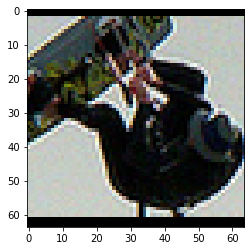

In [16]:
plt.imshow(x_val[0])

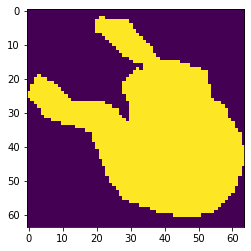

In [17]:
plt.imshow(y_val[0])

In [215]:
x_val_radius = []
y_val_radius = []

In [207]:
DIAM = 5
RADIUS = (DIAM - 1) // 2

In [254]:
x_val_radius = []
y_val_radius = []
i_rand = np.random.choice(x_val.shape[0], 1000, replace=False)
for i in i_rand:
    im = x_val[i]
    j_rand = np.random.choice(range(0+RADIUS, SIDE_LENGTH-RADIUS), 4, replace=False)
    k_rand = np.random.choice(range(0+RADIUS, SIDE_LENGTH-RADIUS), 4, replace=False)
    for j in j_rand:
        for k in k_rand:
            x_val_radius.append(im[j-RADIUS:j+RADIUS+1, k-RADIUS:k+RADIUS+1, :].squeeze())
            y_val_radius.append(y_val[i][j][k].squeeze().item())

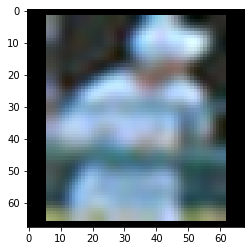

In [265]:
x_val_radius2 = []
y_val_radius2 = []

for i in range(5,15):
    padded = np.pad(x_val[i], ((RADIUS, RADIUS), (RADIUS, RADIUS), (0,0)), mode='constant', constant_values=0)
    plt.imshow(padded)
    if i % 300 == 0:
        print('Iteration', i)
    for j in range(RADIUS, SIDE_LENGTH + RADIUS):
        for k in range(RADIUS, SIDE_LENGTH + RADIUS):
            x_val_radius2.append(padded[j-RADIUS:j+RADIUS+1, k-RADIUS:k+RADIUS+1, :].squeeze())
            y_val_radius2.append(y_val[i][j-RADIUS][k-RADIUS].squeeze().item())

In [260]:
x_val_radius = np.array(x_val_radius)
y_val_radius = np.array(y_val_radius)
print(x_val_radius.shape)
print(y_val_radius.shape)

(16000, 75)
(16000,)


In [268]:
x_val_radius2 = np.array(x_val_radius2)
y_val_radius2 = np.array(y_val_radius2)
print(x_val_radius2.shape)
print(y_val_radius2.shape)

(40960, 75)
(40960,)


In [258]:
x_val_radius = np.reshape(x_val_radius, (x_val_radius.shape[0], -1))


In [267]:
x_val_radius2 = np.reshape(x_val_radius2, (x_val_radius2.shape[0], -1))

In [269]:
OFFSET = 6
VAL = 64*64

In [263]:
x_val_radius = x_val_radius[OFFSET*VAL:(OFFSET + 3)*VAL]
y_val_radius = y_val_radius[OFFSET*VAL:(OFFSET + 3)*VAL]

In [270]:
x_val_radius2 = x_val_radius2[OFFSET*VAL:(OFFSET + 3)*VAL]
y_val_radius2 = y_val_radius2[OFFSET*VAL:(OFFSET + 3)*VAL]

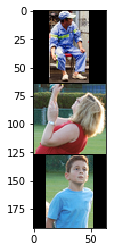

In [206]:
plt.imshow(x_val_radius.reshape((192, 64,3)))

In [81]:
## MODEL

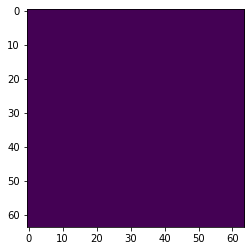

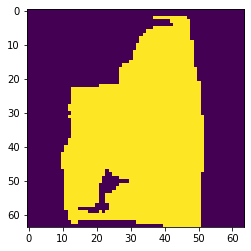

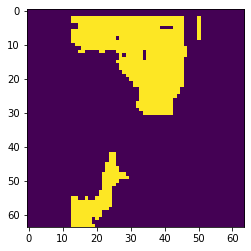

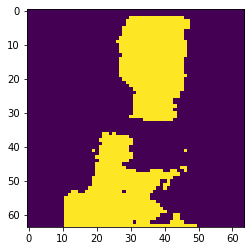

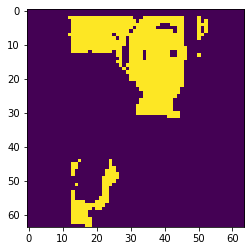

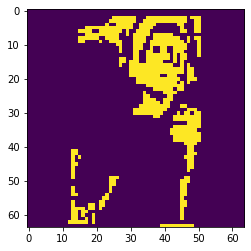

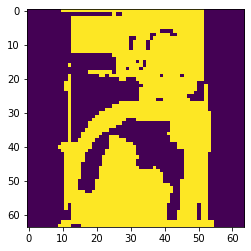

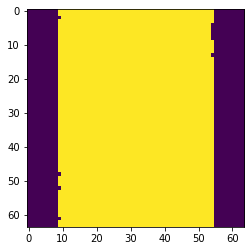

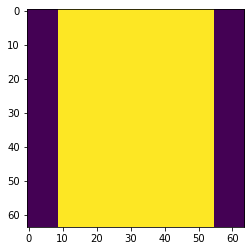

In [273]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
masks = []
gamma_vals = [1E-9, 1E-8, 5E-7, 1E-7, 0.000001, 0.00001, 0.0001, 0.001, 0.01]
for gamma in gamma_vals:
    clf = SVC(gamma=gamma)
    clf.fit(x_val_radius[:-(64*64)], y_val_radius[:-(64*64)])
    outputs = clf.predict(x_val_radius2[-(64*64):])
    mask = outputs.reshape(64, 64)
    masks.append(mask)
    plt.imshow(mask)
    plt.show()

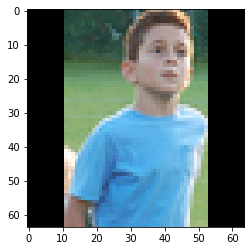

In [170]:
plt.imshow(x_val_radius[-(64*64):].reshape(64,64,3))

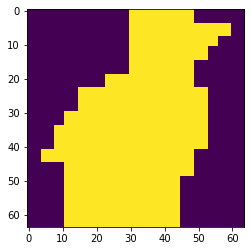

In [168]:
plt.imshow(y_val_radius[-(64*64):].reshape(64,64))

In [172]:
test_x = x_val_radius[-(64*64):].reshape(64,64,3)
test = y_val_radius[-(64*64):].reshape(64,64)
print(masks[2].shape)

(64, 64)


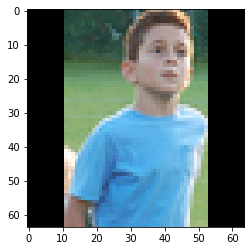

In [173]:
plt.imshow(test_x)

In [280]:
same = np.where(masks[3][:, 11:55] == test[:,11:55])

In [281]:
accuracy = len(same[0]) / (64*64)

In [282]:
print('Accuracy:', accuracy)

Accuracy: 0.511962890625
